In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tsai.basics import *
from datetime import datetime
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint

dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

df = pd.read_csv("recommendation_components_97e4fa3e-a106-40fc-9d11-4d01e61e5d16.csv", date_parser=dateparse, parse_dates=["Date"])
df["Class"] = df.apply(
    lambda x: 0 if -0.01 <= x["Relative change"] <= 0.01 else 1 if x["Relative change"] > 0.01 else -1,
    axis=1
)
ticker_list = df["Ticker"].unique()

def create_sequences(df, n_steps):
    X, y = [], []
    for i in range(n_steps, len(df)):
        X.append(df.iloc[i-n_steps:i][features].values)
        y.append(df.iloc[i]['Class'])
    return np.array(X), np.array(y)

n_steps_list = [1]
n_trainings = 10

df_results = pd.DataFrame()

for ticker in ticker_list:
    ticker_df = df[df["Ticker"] == ticker]
    df_pivot  = ticker_df.pivot_table(index=["Date", "Class"], columns=["Component", "Trader"], values="Score", fill_value=0)
    df_flat = df_pivot.reset_index()

    for n_steps in n_steps_list:

        # Prepare X and y
        features = df_flat.columns[2:]
        X, y = create_sequences(df_flat, n_steps=n_steps)
        # One hot encode y
        y = to_categorical(y, num_classes=3)

        # Split the data into training (60%), validation (20%), and testing (20%) sets based on time series indices
        train_size = int(len(X) * 0.6)
        val_size = int(len(X) * 0.2)
        X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
        y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

        for run in range(n_trainings):

            # Define the LSTM model
            model = Sequential()
            model.add(LSTM(100, activation='relu', input_shape=(n_steps, X.shape[2]), return_sequences=True))
            model.add(LSTM(100, activation='relu', input_shape=(n_steps, X.shape[2]), return_sequences=False))
            model.add(Dense(3, activation='softmax'))
            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

            # Define the ModelCheckpoint callback
            checkpoint = ModelCheckpoint(
                f'models/best_model_{ticker}_{n_steps}.h5', 
                monitor='val_accuracy', 
                save_best_only=True, 
                mode='max', 
                verbose=0
            )

            # Train the model with ModelCheckpoint
            model.fit(
                X_train, y_train, 
                epochs=75, 
                batch_size=32, 
                validation_data=(X_val, y_val), 
                callbacks=[checkpoint], 
                verbose=0
            )

            # Load the best model
            model.load_weights(f'models/best_model_{ticker}_{n_steps}.h5')

            # Evaluate the model
            loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

            # Calculate and store the average accuracy
            result_dict = {
                "Ticker": ticker,
                "Run": run,
                "n": n_steps,
                "Test Accuracy": accuracy
            }
            df_results = pd.concat([df_results, pd.DataFrame([result_dict])], ignore_index=True)
            print(f'Test Accuracy for {ticker}, n_step {n_steps}, run {run + 1}: {accuracy*100:.2f}%')

print(df_results)

Test Accuracy for AAPL, n_step 1, run 1: 55.45%
Test Accuracy for AAPL, n_step 1, run 2: 49.50%
Test Accuracy for AAPL, n_step 1, run 3: 51.49%
Test Accuracy for AAPL, n_step 1, run 4: 56.44%
Test Accuracy for AAPL, n_step 1, run 5: 54.46%
Test Accuracy for AAPL, n_step 1, run 6: 56.44%
Test Accuracy for AAPL, n_step 1, run 7: 55.45%
Test Accuracy for AAPL, n_step 1, run 8: 56.44%
Test Accuracy for AAPL, n_step 1, run 9: 50.50%
Test Accuracy for AAPL, n_step 1, run 10: 56.44%
Test Accuracy for BA, n_step 1, run 1: 56.44%
Test Accuracy for BA, n_step 1, run 2: 56.44%
Test Accuracy for BA, n_step 1, run 3: 53.47%
Test Accuracy for BA, n_step 1, run 4: 53.47%
Test Accuracy for BA, n_step 1, run 5: 58.42%
Test Accuracy for BA, n_step 1, run 6: 55.45%
Test Accuracy for BA, n_step 1, run 7: 57.43%
Test Accuracy for BA, n_step 1, run 8: 60.40%
Test Accuracy for BA, n_step 1, run 9: 59.41%
Test Accuracy for BA, n_step 1, run 10: 53.47%
Test Accuracy for WMT, n_step 1, run 1: 54.46%
Test Accura

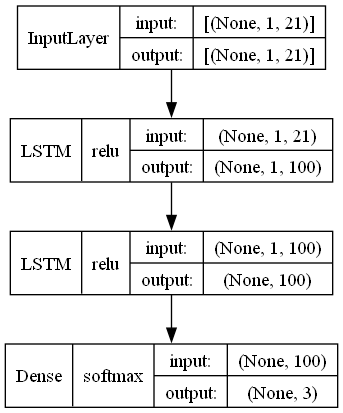

In [27]:
from keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, show_layer_activations=True)

Ticker
AAPL    0.542574
BA      0.564356
JPM     0.528713
NKE     0.505941
WMT     0.542574
Name: Test Accuracy, dtype: float64


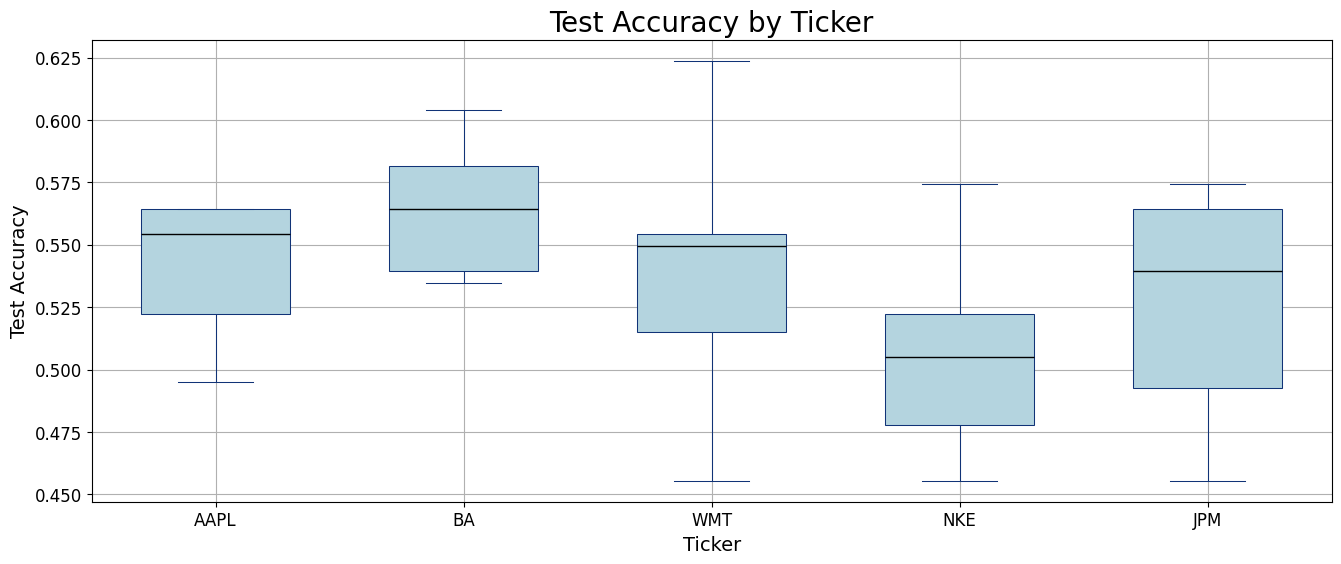

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

df_results_fitered = df_results[df_results["n"] == 1]
print(df_results_fitered.groupby("Ticker")["Test Accuracy"].mean())

# Set the figure size
plt.figure(figsize=(16, 6))

# Create the boxplot
sns.boxplot(data=df_results_fitered, x="Ticker", y="Test Accuracy", linecolor="#137", linewidth=.75, whis=(0, 100), width=0.75, gap=0.2, color="lightblue", medianprops={"color": "black", "linewidth": 1})

# Add a title to the plot
plt.title("Test Accuracy by Ticker", fontsize=20)

# Set the font size of the X and Y labels
plt.xlabel("Ticker", fontsize=14)
plt.ylabel("Test Accuracy", fontsize=14)

# Set the font size of the X and Y tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a grid
plt.grid(True)
# Show the plot
plt.show()

In [30]:
print(model.summary())

Model: "sequential_339"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_678 (LSTM)             (None, 1, 100)            48800     
                                                                 
 lstm_679 (LSTM)             (None, 100)               80400     
                                                                 
 dense_339 (Dense)           (None, 3)                 303       
                                                                 
Total params: 129503 (505.87 KB)
Trainable params: 129503 (505.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [29]:
df = pd.read_csv("recommendation_components_97e4fa3e-a106-40fc-9d11-4d01e61e5d16.csv", date_parser=dateparse, parse_dates=["Date"])
df["Class"] = df.apply(
    lambda x: 0 if -0.01 <= x["Relative change"] <= 0.01 else 1 if x["Relative change"] > 0.01 else -1,
    axis=1
)
df_pivot  = df.pivot_table(index=["Date", "Ticker"], values="Class", fill_value=0)
df_flat = df_pivot.reset_index()
print(df_flat.groupby("Class").count())

       Date  Ticker
Class              
-1.0   1208    1208
 0.0     13      13
 1.0   1289    1289
